In [2]:
!git clone https://github.com/vncorenlp/VnCoreNLP.git

Cloning into 'VnCoreNLP'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 259 (delta 17), reused 33 (delta 11), pack-reused 212 (from 1)
Receiving objects: 100% (259/259), 237.79 MiB | 39.64 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [2]:
import re
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, DatasetDict, Dataset
from vncorenlp import VnCoreNLP

In [3]:
dataset = load_dataset('sonlam1102/vihsd')
dataset

DatasetDict({
    train: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 24048
    })
    validation: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 6680
    })
})

In [4]:
class_mapping = {0: 'CLEAN', 1: 'OFFENSIVE', 2: 'HATE'}
text_column = 'free_text'
label_column = 'label_id'

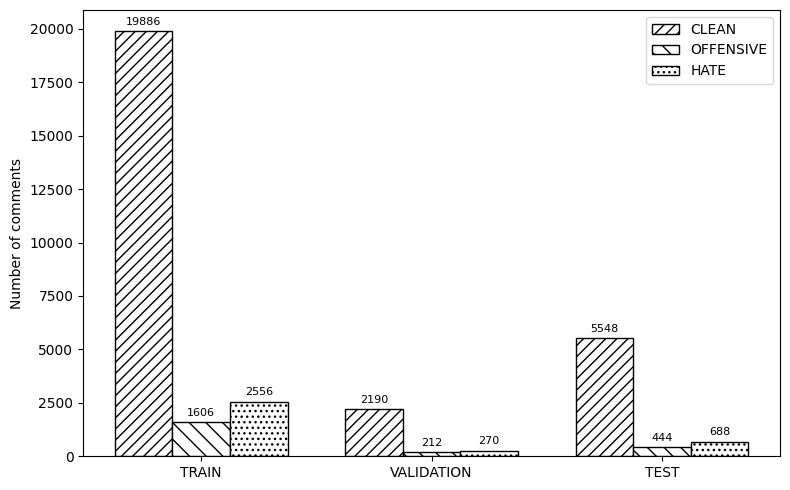

In [5]:
def count_labels_for_split(split_name):
    split_df = pd.DataFrame(dataset[split_name])
    return split_df.value_counts(label_column).to_dict()


split_labels = [split_name.upper() for split_name in dataset.keys()]

label_counts_by_class = defaultdict(list)
for split_name in dataset:
    label_counts = count_labels_for_split(split_name)
    for counts, class_name in class_mapping.items():
        label_counts_by_class[class_name].append(label_counts[counts])


# Create grouped bar chart
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(split_labels))
bar_width = 0.25
hatches = ['///', '\\\\', '...']

def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height}',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=8,
        )

# Plot bar for each class
for i, (label_name, counts) in enumerate(label_counts_by_class.items()):
    rects = ax.bar(
        x + bar_width * i,
        counts,
        bar_width,
        label=label_name,
        hatch=hatches[i],
        edgecolor='black',
        color='white',
    )
    annotate_bars(rects)

ax.set_ylabel('Number of comments')
ax.set_xticks(x + bar_width)
ax.set_xticklabels(split_labels)
ax.legend()

plt.tight_layout()
plt.show()

In [6]:
train = pd.DataFrame(dataset['train'])
train.head()

,free_text,label_id
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2
2,Đậu Văn Cường giờ giống thằng sida hơn à,0
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24048 entries, 0 to 24047
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   free_text  24046 non-null  object
 1   label_id   24048 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 375.9+ KB


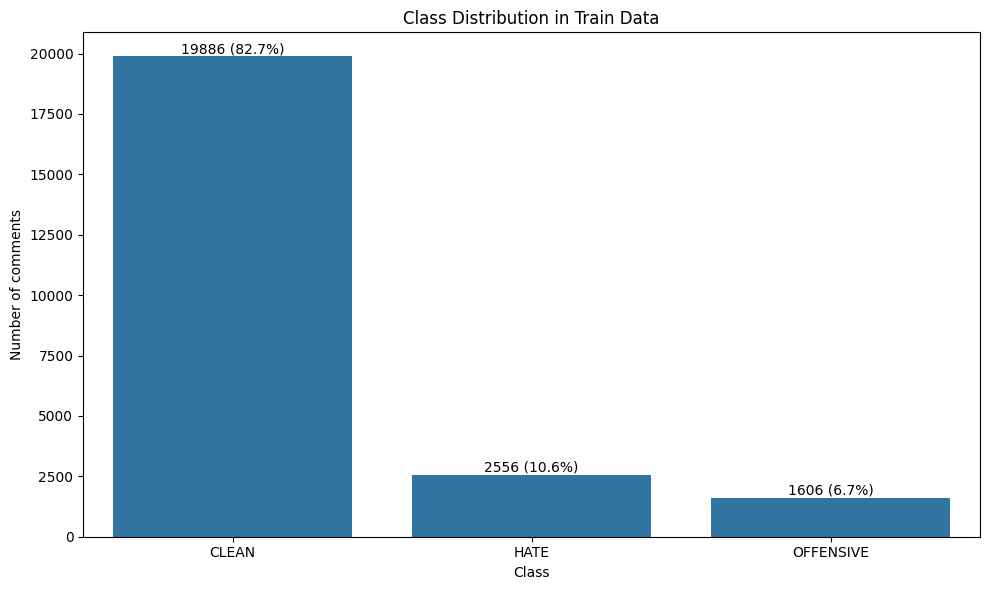

In [8]:
def plot_class_distribution(data, title='Class Distribution in Train Data'):
    # Class distribution
    data_df = pd.DataFrame(data)
    data_df['class'] = data_df[label_column].map(class_mapping)

    class_distribution = data_df['class'].value_counts()

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data_df, x='class')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of comments')

    # Add count values on top of each bar
    for i, count in enumerate(class_distribution):
        plt.text(
            i, count, f'{count} ({count / len(data_df) * 100:.1f}%)', ha='center', va='bottom'
        )

    plt.tight_layout()
    plt.show()

plot_class_distribution(train)

In [12]:
def preprocess_text(text):
    if not text:
        return ''
    text = re.sub(r'[^\w\s]', ' ', str(text))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def tokenize_text(text, annotator):
    if not text:
        return []

    try:
        word_segmented = annotator.tokenize(text)
        tokens = []
        for sentence in word_segmented:
            tokens.extend(sentence)
        return [token.strip().lower() for token in tokens if token.strip()]
    except Exception as e:
        print(e)
        return []

In [13]:
annotator = VnCoreNLP(
    "/kaggle/working/VnCoreNLP/VnCoreNLP-1.2.jar",
    annotators="wseg,pos",
    max_heap_size='-Xmx500m'
)

train['clean_text'] = train[text_column].apply(preprocess_text)
train['tokens'] = train['clean_text'].apply(tokenize_text, annotator=annotator)

# Calculate sentence lengths and all tokens
sentence_lengths = [len(tokens) for tokens in train['tokens']]
all_tokens = [token for tokens in train['tokens'] for token in tokens]

# Calculate statistics
total_sentences = len(sentence_lengths)
total_tokens = len(all_tokens)
avg_length = np.mean(sentence_lengths) if sentence_lengths else 0
max_length = max(sentence_lengths) if sentence_lengths else 0
min_length = min(sentence_lengths) if sentence_lengths else 0

# Count unique words
vocab_counter = Counter(all_tokens)
vocab_size = len(vocab_counter)

# Most common words
most_common_words = vocab_counter.most_common(20)

annotator.close()

In [14]:
print(f'General Statistics:')
print(f'- Total samples: {len(train)}')
print(f'- Total sentences: {total_sentences:,}')
print(f'- Total tokens: {total_tokens:,}')

print(f'\nSentence Length Statistics:')
print(f'- Average length: {avg_length:.2f} tokens')
print(f'- Minimum length: {min_length} tokens')
print(f'- Maximum length: {max_length} tokens')

print(f'\nVocabulary Statistics:')
print(f'- Total vocabulary: {vocab_size:,}')

for label in train[label_column].unique():
    subset = train[train[label_column] == label]
    sentence_lengths = [len(tokens) for tokens in subset['tokens']]
    all_tokens = [token for tokens in subset['tokens'] for token in tokens]

    print(f'\nLabel: {class_mapping[label]}')
    print(f'- Total samples: {len(subset)}')
    print(f'- Total tokens: {len(all_tokens):,}')
    print(f'- Total vocabulary: {len(set(all_tokens)):,}')
    print(f'- Average length: {np.mean(sentence_lengths):.2f} tokens')

General Statistics:
- Total samples: 24048
- Total sentences: 24,048
- Total tokens: 235,412

Sentence Length Statistics:
- Average length: 9.79 tokens
- Minimum length: 0 tokens
- Maximum length: 2220 tokens

Vocabulary Statistics:
- Total vocabulary: 18,365

Label: CLEAN
- Total samples: 19886
- Total tokens: 175,949
- Total vocabulary: 15,982
- Average length: 8.85 tokens

Label: HATE
- Total samples: 2556
- Total tokens: 44,577
- Total vocabulary: 6,270
- Average length: 17.44 tokens

Label: OFFENSIVE
- Total samples: 1606
- Total tokens: 14,886
- Total vocabulary: 3,469
- Average length: 9.27 tokens


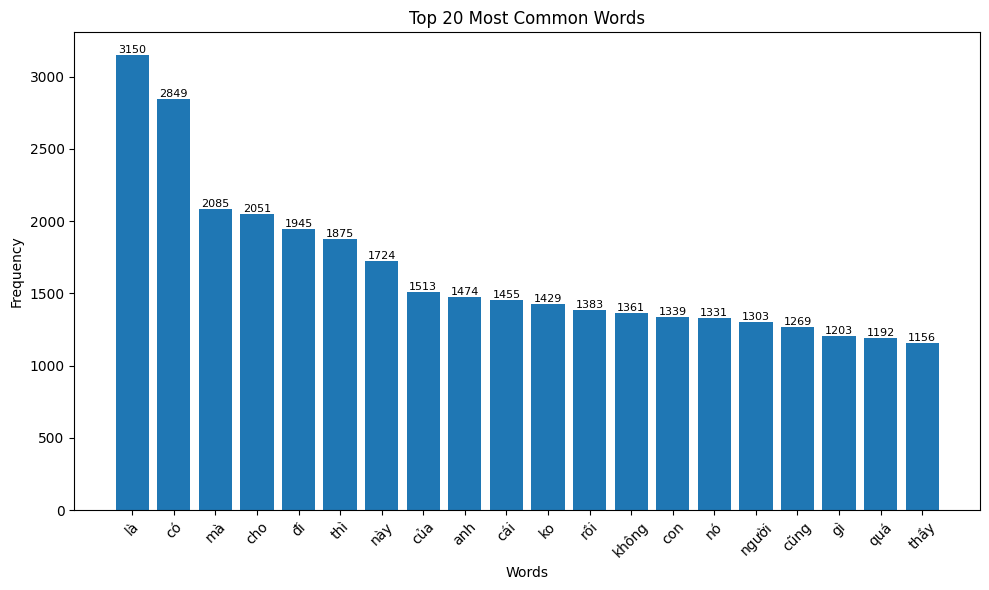

In [15]:
# Plot 20 most common words
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, align='center')
for i, word in enumerate(words):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=8)
plt.xticks(range(len(words)), words, rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.tight_layout()
plt.show()

# Augmented Data

In [9]:
# Load augmented eda data
aug_eda_offensive = pd.read_csv('data/aug_eda_offensive.csv', sep='|')
aug_eda_hate = pd.read_csv('data/aug_eda_hate.csv', sep='|')

# Add to train in dataset
eda_dataset = DatasetDict(dataset)
eda_dataset['train'] = Dataset.from_pandas(
    pd.concat([train, aug_eda_offensive, aug_eda_hate], ignore_index=True)
)
eda_dataset

DatasetDict({
    train: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 34290
    })
    validation: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 6680
    })
})

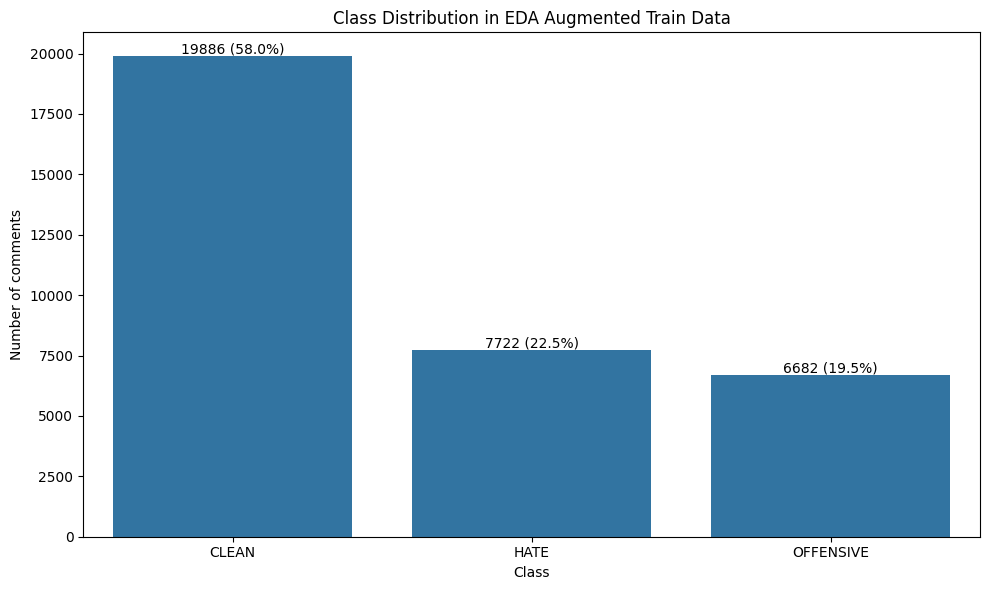

In [10]:
plot_class_distribution(eda_dataset['train'], 'Class Distribution in EDA Augmented Train Data')

In [11]:
# Load augmented llm data
aug_llm_offensive = pd.read_csv('data/aug_llm_offensive.csv', sep='|')
aug_llm_hate = pd.read_csv('data/aug_llm_hate.csv', sep='|')

# Add to train in dataset
llm_dataset = DatasetDict(dataset)
llm_dataset['train'] = Dataset.from_pandas(
    pd.concat([train, aug_llm_offensive, aug_llm_hate], ignore_index=True)
)
llm_dataset

DatasetDict({
    train: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 34048
    })
    validation: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 6680
    })
})

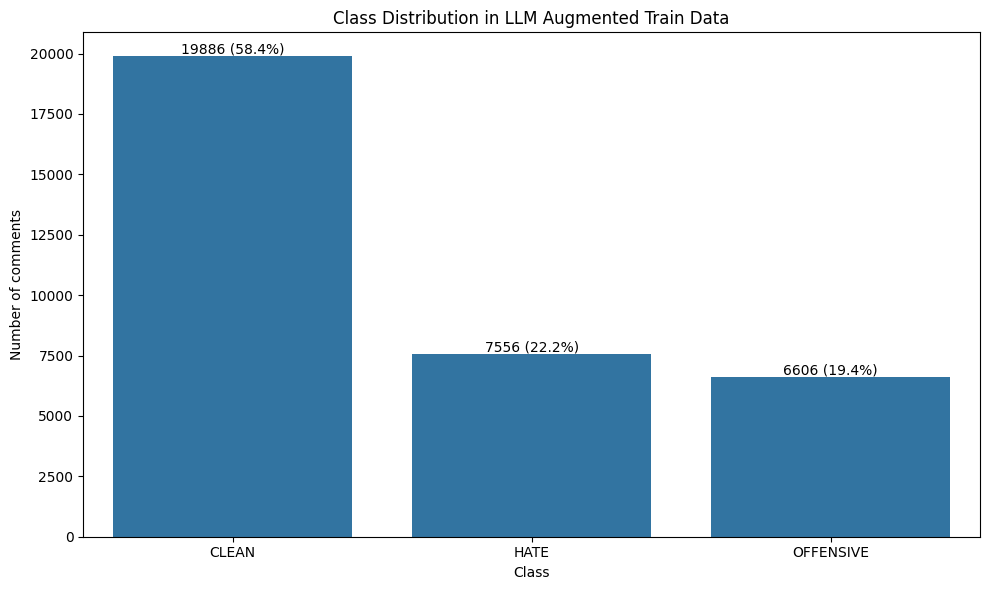

In [12]:
plot_class_distribution(llm_dataset['train'], 'Class Distribution in LLM Augmented Train Data')